In [115]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipykernel_27163/2008134232.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# The data

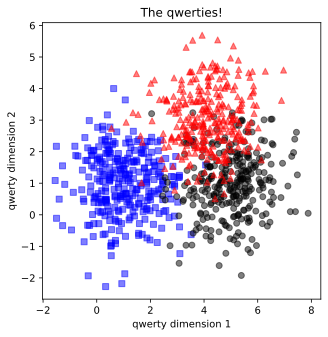

In [116]:
# create data

nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 3 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.hstack((  np.zeros((nPerClust)),
                         np.ones( (nPerClust)),
                       1+np.ones( (nPerClust))  ))

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [117]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [118]:
# how many batches are there?

print(f'There are {len(train_loader)} batches, each with {batchsize} samples.')

There are 50 batches, each with 16 samples.


# The model

In [119]:
# Create a neural network model with a specified optimizer algorithm

# Explanation:
# In this code snippet, we define a function to create a neural network model with a user-specified optimizer algorithm.

def createTheQwertyNet(optimizerAlgo):

    # Explanation:
    # Within the function, we define a neural network class called `qwertyNet`. This class defines the architecture of the neural network, including input and output layers, as well as hidden layers.

    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            ### input layer
            self.input = nn.Linear(2, 8)

            ### hidden layer
            self.fc1 = nn.Linear(8, 8)

            ### output layer
            self.output = nn.Linear(8, 3)

        # forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            return self.output(x)

    # Explanation:
    # Next, we create an instance of the `qwertyNet` class, which represents our neural network model.

    net = qwertyNet()

    # Explanation:
    # We specify the loss function to be used during training. In this case, we use the Cross-Entropy Loss, which is common for classification tasks.

    lossfun = nn.CrossEntropyLoss()

    # Explanation:
    # The user specifies the optimizer algorithm they want to use through the `optimizerAlgo` parameter. We dynamically select the optimizer class based on the provided algorithm using `getattr`.

    optifun = getattr(torch.optim, optimizerAlgo)

    # Explanation:
    # We initialize the optimizer with the model parameters and a specified learning rate (lr=.01).

    optimizer = optifun(net.parameters(), lr=.01)

    # Explanation:
    # Finally, we return the neural network model (`net`), the chosen loss function (`lossfun`), and the optimizer (`optimizer`) as the output of the function.

    return net, lossfun, optimizer


In [120]:
# test the model with optimizer type as input

# try 'SGD', 'RMSprop', and 'Adam'
optim = createTheQwertyNet('Adam')[2]
optim

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

# A function that trains the model

In [103]:
def function2trainTheModel(optimizerType):

  # number of epochs
  numepochs = 50
  
  # create a new model
  net,lossfun,optimizer = createTheQwertyNet(optimizerType)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) ) 
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# A function that plots the results

In [104]:
# a function that plots the results
def plotTheResults(optimizerType):

  # compute accuracy over entire dataset (train+test)
  yHat = net(data)
  predictions = torch.argmax(yHat,axis=1)
  accuracy = (predictions == labels).float()
  totalAcc = torch.mean(100*accuracy).item()

  # and accuracy by group
  accuracyByGroup = np.zeros(3)
  for i in range(3):
    accuracyByGroup[i] = 100*torch.mean(accuracy[labels==i])


  # create the figure
  fig,ax = plt.subplots(2,2,figsize=(10,6))

  # plot the loss function
  ax[0,0].plot(losses.detach())
  ax[0,0].set_ylabel('Loss')
  ax[0,0].set_xlabel('epoch')
  ax[0,0].set_title(f'{optimizerType}: Losses')

  # plot the accuracy functions
  ax[0,1].plot(trainAcc,label='Train')
  ax[0,1].plot(testAcc,label='Test')
  ax[0,1].set_ylabel('Accuracy (%)')
  ax[0,1].set_xlabel('Epoch')
  ax[0,1].set_title(f'{optimizerType}: Accuracy')
  ax[0,1].legend()

  # plot overall accuracy by group
  ax[1,0].bar(range(3),accuracyByGroup)
  ax[1,0].set_ylim([np.min(accuracyByGroup)-5,np.max(accuracyByGroup)+5])
  ax[1,0].set_xticks([0,1,2])
  ax[1,0].set_xlabel('Group')
  ax[1,0].set_ylabel('Accuracy (%)')
  ax[1,0].set_title(f'{optimizerType}: Accuracy by group')

  # scatterplot of correct and incorrect labeled data
  colorShapes = [ 'bs','ko','g^' ] # data markers
  for i in range(3):
    # plot all data points
    ax[1,1].plot(data[labels==i,0],data[labels==i,1],colorShapes[i],
                 alpha=.3,label=f'Group {i}')
    
    # cross-out the incorrect ones
    idxErr = (accuracy==0) & (labels==i)
    ax[1,1].plot(data[idxErr,0],data[idxErr,1],'rx')

  ax[1,1].set_title(f'{optimizerType}: Total accuracy: {totalAcc:.2f}%')
  ax[1,1].set_xlabel('qwerty dimension 1')
  ax[1,1].set_ylabel('qwerty dimension 2')
  ax[1,1].legend()
  
  plt.tight_layout()
  plt.show()

# Now for the optimizer comparison

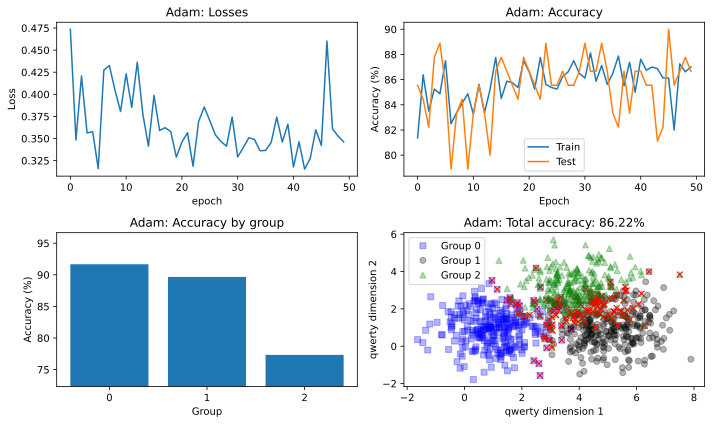

In [105]:
# Run the model training and visualization for one optimizer

# Explanation:
# In this code snippet, we specify a particular optimizer type ('Adam') and then run the model training using that optimizer. After training, we visualize the results.

# Specify the optimizer type
optimizerType = 'Adam'

# Explanation:
# We call a function named `function2trainTheModel` and provide the chosen optimizer type as an argument. This function likely trains a neural network model using the specified optimizer.

# The function returns training accuracy, test accuracy, losses, and the trained neural network model itself.
trainAcc, testAcc, losses, net = function2trainTheModel(optimizerType)

# Explanation:
# After training the model, we call another function named `plotTheResults` to visualize the training results, presumably including loss curves and accuracy metrics.

# Visualize the training results for the specified optimizer
plotTheResults(optimizerType)


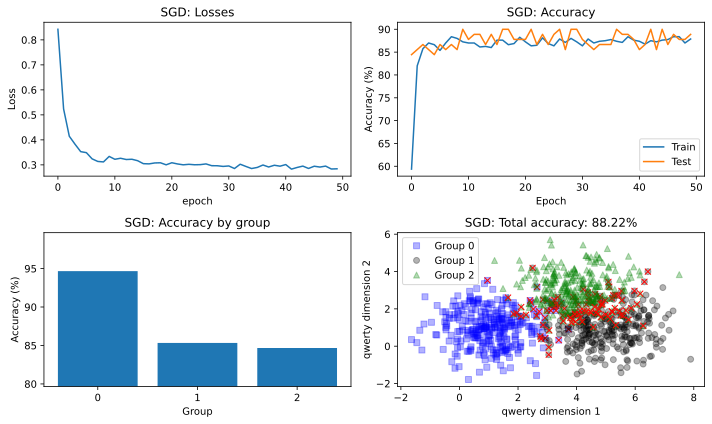

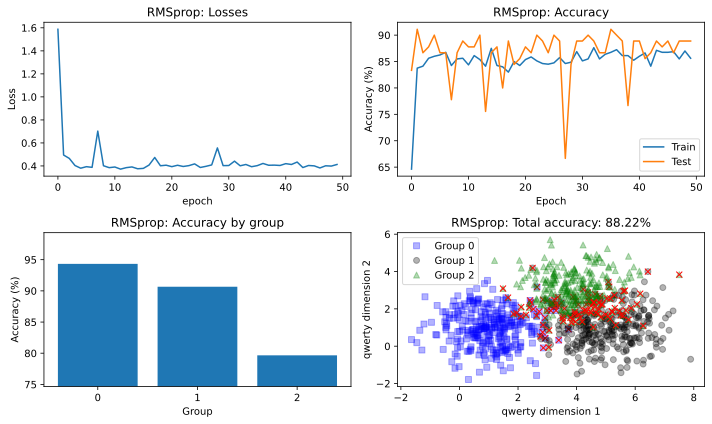

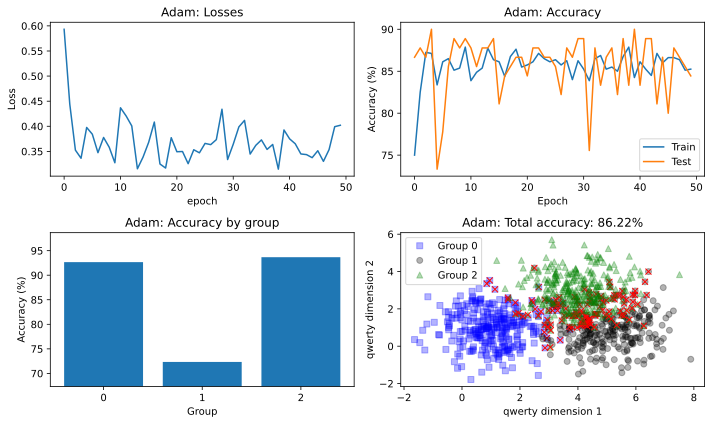

In [106]:
# Run through all optimizer types and evaluate performance

# Explanation:
# In this code snippet, we iterate through different optimizer types ('SGD', 'RMSprop', 'Adam'), train models using each optimizer, and evaluate their performance. We then calculate the average performance across these optimizers.

# Initialize a list to store performance results
performance = []

# Explanation:
# We create an empty list called 'performance' to store performance metrics for different optimizers.

# Iterate through optimizer types
for opto in ['SGD', 'RMSprop', 'Adam']:
    
    # Explanation:
    # We loop through a list of optimizer types, including 'SGD', 'RMSprop', and 'Adam', to evaluate each one.

    # Train the model and obtain performance metrics
    trainAcc, testAcc, losses, net = function2trainTheModel(opto)
    
    # Explanation:
    # We call the function 'function2trainTheModel' with the current optimizer type as an argument. This function likely trains a neural network model using the specified optimizer and returns training and testing accuracy, loss values, and the trained model.

    # Visualize the training results for the current optimizer
    plotTheResults(opto)
    
    # Explanation:
    # We call a function named 'plotTheResults' to visualize the training results for the current optimizer. This visualization likely includes loss curves and accuracy metrics.

    # Calculate and store the final results
    train_avg = np.mean(trainAcc[-10:])
    test_avg = np.mean(testAcc[-10:])
    
    # Explanation:
    # We calculate the average training and testing accuracy over the last 10 epochs of training. This provides a summary of the model's performance.

    # We append the performance results for the current optimizer to the 'performance' list in the format 'optimizer: train_accuracy%, test_accuracy%'.
    performance.append(f'{opto}: train {train_avg:.1f}%, test {test_avg:.1f}%')

# Explanation:
# After iterating through all optimizer types, we have evaluated the performance of the neural network models trained with different optimizers. The 'performance' list now contains a summary of each optimizer's performance on both training and testing data.


In [107]:
performance

['SGD: train 87.6%, test 87.8%',
 'RMSprop: train 86.2%, test 88.0%',
 'Adam: train 85.9%, test 85.3%']

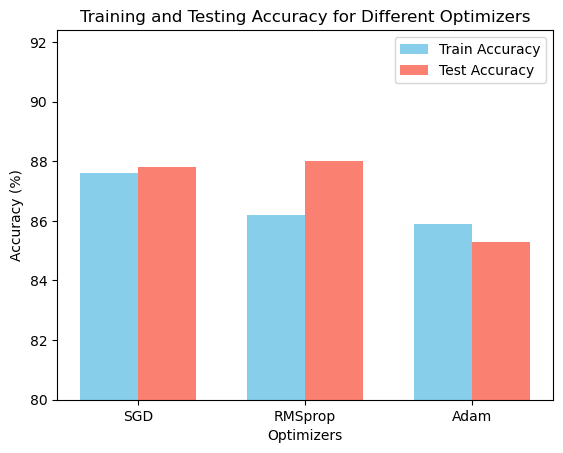

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the optimizers' performance
optimizers = ['SGD', 'RMSprop', 'Adam']
train_acc = [87.6, 86.2, 85.9]
test_acc = [87.8, 88.0, 85.3]

# Bar width and positions
bar_width = 0.35
index = np.arange(len(optimizers))

# Plotting
fig, ax = plt.subplots()
train_bar = ax.bar(index, train_acc, bar_width, label='Train Accuracy', color='skyblue')
test_bar = ax.bar(index + bar_width, test_acc, bar_width, label='Test Accuracy', color='salmon')

# Labels and title
ax.set_xlabel('Optimizers')
ax.set_ylabel('Accuracy (%)')
ax.set_ylim(80)
ax.set_title('Training and Testing Accuracy for Different Optimizers')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(optimizers)
ax.legend()

# Display
plt.show()

# Additional explorations

In [108]:
# 1) Accuracy seems to be different between the different qwerties categories. Is this consistent across the optimizers?
#    Or does it seem like some optimizers are better at some categories? How do you interpret your answer, and what does
#    it indicate about metaparameters of DL and their effects on performance?
# 
# 2) The results here indicate that all three optimizers perform roughly equally well, but SGD needs more training. Is 
#    that still the case with a smaller or larger learning rate?
# 
# 3) The method of showing the final performance (printing out a list) is... not very pretty. What kind of visualization
#    do you think would better illustrate the performances across the optimizers? Code it! 
# 